# Gaussian Process Regression and Classification with Elliptical Slice Sampling

[Elliptical slice sampling](https://arxiv.org/abs/1001.0175) is a variant of slice sampling that allows sampling from distributions with multivariate Gaussian prior and arbitrary likelihood. It is generally about as fast as regular slice sampling, mixes well even when the prior covariance might otherwise induce a strong dependence between samples, and does not depend on any tuning parameters. It can be useful when working with Gaussian processes, in which a multivariate Gaussian prior is used to impose a covariance structure on some latent function.

This notebook provides examples of how to use PyMC3's elliptical slice sampler to perform Gaussian process regression and classification. Since the focus of these examples are to show how to of elliptical slice sampling to sample from the posterior rather than to show how to fit the covariance kernel parameters, we assume that the kernel parameters are known.

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline

## Gaussian Process Regression

In Gaussian process regression, the prior $f$ is a multivariate normal with mean zero and covariance matrix $K$, and the likelihood is a factored normal (or, equivalently, a multivariate normal with diagonal covariance) with mean $f$ and variance $\sigma^2_n$:

\begin{equation}
f \sim N(\boldsymbol{0}, K) \\
L(y | f, \sigma^2_n) = \Pi_n N(f_n, \sigma^2_n)
\end{equation}

### Generate some example data

We generate some data from Gaussian process at 30 random points in $[0, 3]$ and interpolate the function's value in this interval.

In [9]:
np.random.seed(1)

# Number of training points
n = 30
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * tt.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-12 * tt.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

### Examine actual posterior distribution

The posterior is analytically tractable so we can compute the posterior mean explicitly. Rather than computing the inverse of the covariance matrix `K`, we use the numerically stable calculation described Algorithm 2.1 in the book "Gaussian Processes for Machine Learning" (2006) by Rasmussen and Williams, which is [available online for free](http://www.gaussianprocess.org/gpml/).

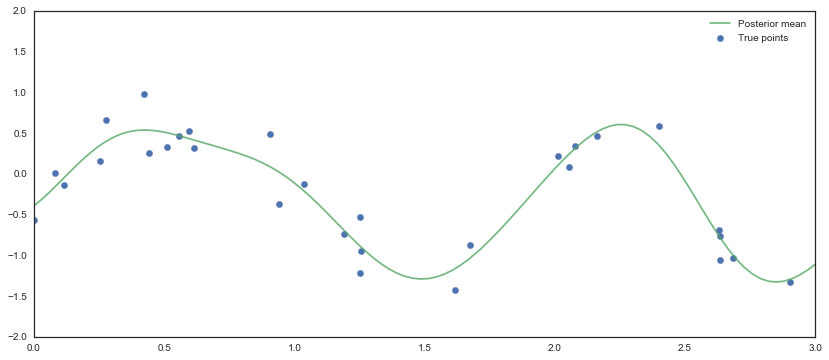

In [10]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

### Sample from posterior distribution

In [12]:
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(n, ))
    
    # Likelihood
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))
    
    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

### Evaluate posterior fit

The posterior samples are consistent with the analytically derived posterior and behaves how one would expect–narrower near areas with lots of observations and wider in areas with more uncertainty.

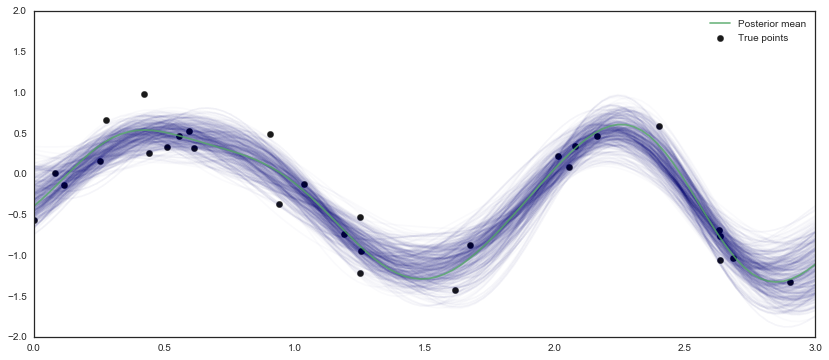

In [13]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);

## Gaussian Process Classification

In Gaussian process classification, the likelihood is not normal and thus the posterior is not analytically tractable. The prior is again a multivariate normal with covariance matrix $K$, and the likelihood is the standard likelihood for logistic regression:

\begin{equation}
L(y | f) = \Pi_n \sigma(y_n, f_n)
\end{equation}

### Generate some example data

We generate random samples from a Gaussian process, assign any points greater than zero to a "positive" class, and assign all other points to a "negative" class.

In [14]:
np.random.seed(5)
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_stable.eval())

# Separate data into positive and negative classes
f[f > 0] = 1
f[f <= 0] = 0

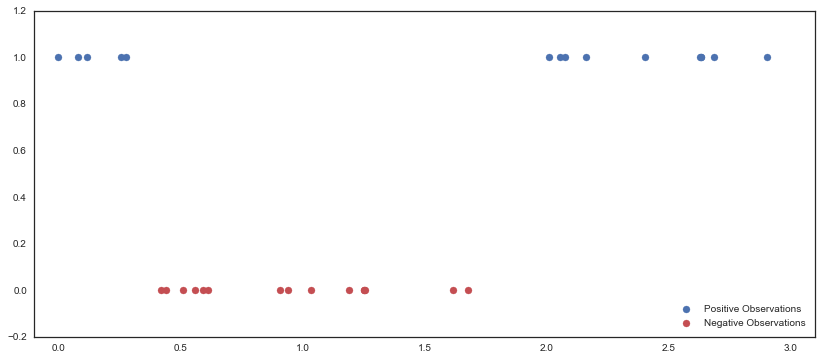

In [15]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(f == 0, f), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(f == 1, f), color='r', label='Negative Observations');
ax.legend(loc='lower right');
ax.set_xlim(-0.1, 3.1);
ax.set_ylim(-0.2, 1.2);

### Sample from posterior distribution

In [16]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)
    
    # Binomial likelihood
    y = pm.Binomial('y', observed=f, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

### Evaluate posterior fit

The posterior looks good, though the fit is, unsurprisingly, erratic outside the range of the observed data.

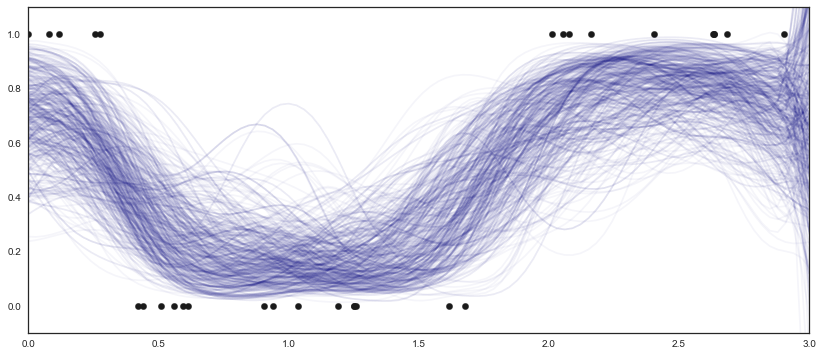

In [17]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, f, s=40, color='k');
ax.set_xlim(0, 3);
ax.set_ylim(-0.1, 1.1);